In [1]:
import sys
sys.path.insert(0, '/Users/kerong/')
from helper import *

import warnings
warnings.filterwarnings("ignore")

import os
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='keryums', api_key='G5YsVJOebOZh0nhwk44q')

import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [2]:
data_filepath = '/Users/kerong/data/veteran_suicide/data_out/'

for filename in glob.glob(os.path.join(data_filepath, '*.csv')):
    print(filename)

/Users/kerong/data/veteran_suicide/data_out/va_spend_2016_20190118_1449.csv
/Users/kerong/data/veteran_suicide/data_out/state_by_age_wide_20190117_1624.csv
/Users/kerong/data/veteran_suicide/data_out/va_spend_2016_20190117_1650.csv
/Users/kerong/data/veteran_suicide/data_out/state_by_method_20190117_1648.csv
/Users/kerong/data/veteran_suicide/data_out/state_by_sex_wide_20190117_1620.csv


In [3]:
state_by_age = pd.read_csv('/Users/kerong/data/veteran_suicide/data_out/state_by_age_wide_20190117_1624.csv')
state_by_sex = pd.read_csv('/Users/kerong/data/veteran_suicide/data_out/state_by_sex_wide_20190117_1620.csv')
state_by_method = pd.read_csv('/Users/kerong/data/veteran_suicide/data_out/state_by_method_20190117_1648.csv')

# Suicides by Sex

## Comparison of Rates

Since each 10 count bin is indicated by its lower bound, let's estimate a point estimate for each state using the bin's mean/median.

In [4]:
suicides_by_sex = state_by_sex.groupby('sex')['suicides_point_est'].sum().reset_index()
suicides_by_sex

,sex,suicides_point_est
0,Female,106.0
1,Male,5779.0


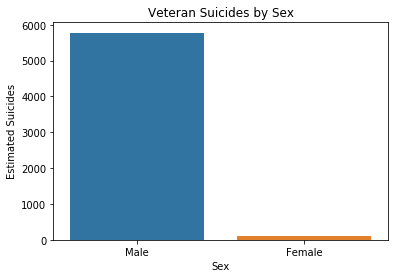

In [5]:
suicides_by_sex.sort_values(by='sex', ascending=False, inplace=True) #sort for plotting 
ax = sns.barplot(x='sex', y='suicides_point_est', data = suicides_by_sex[~(suicides_by_sex.sex=='Total')])
ax.set_title('Veteran Suicides by Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Estimated Suicides')
plt.show()

__Notice the disparity in suicides by gender. Is this wholly explicable by differences in the number of male and female veterans?__

As the VA did not publish suicide rates by gender (unlike it does for the other attributes, age and suicide method), let's calculate this by pulling in a veteran population table. We consider population figures as of September 2015 since this is the population from which suicides in 2016 occurred. 

In [6]:
total_by_sex = state_by_sex.groupby('sex')['veterans'].sum().reset_index()
total_by_sex

,sex,veterans
0,Female,63642419.0
1,Male,421985510.0


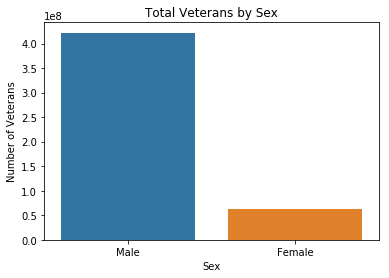

In [7]:
total_by_sex.sort_values(by='sex', ascending=False, inplace=True) #sort for plotting 
ax = sns.barplot(x='sex', y='veterans', data = total_by_sex)
ax.set_title('Total Veterans by Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Number of Veterans')
plt.show()

__Is the proportion the same?__

In [8]:
counts_by_sex = state_by_sex.groupby('sex')[['suicides_point_est', 'veterans']].sum().reset_index()
rate_by_sex = counts_by_sex[['suicides_point_est', 'veterans']].apply(lambda x: x[0]/x[1], axis=1).reset_index()
sex_map = {0:'female',1:'male'} 
rate_by_sex.replace({'index': sex_map}, inplace=True)
rate_by_sex.rename(columns = {'index':'sex', 0:'rate'}, inplace=True)

In [9]:
rate_by_sex

,sex,rate
0,female,0.000002
1,male,0.000014


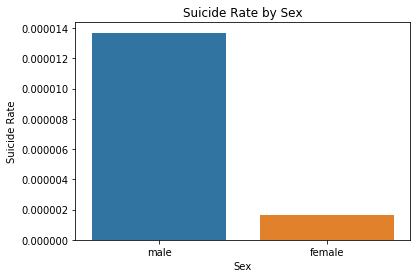

In [10]:
rate_by_sex.sort_values(by='sex', ascending=False, inplace=True) #sort for plotting 
ax = sns.barplot(x='sex', y='rate', data = rate_by_sex)
ax.set_title('Suicide Rate by Sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Suicide Rate')
plt.show()

The chart above shows a different in rates of suicide between male and female veterans. Let's formalize this with a test of proportions to see if the difference in rates are statistically significantly.

In [11]:
count = np.array(counts_by_sex.suicides_point_est)
nobs = np.array(counts_by_sex.veterans)
stat, pval = proportions_ztest(count,nobs)

print('p-value of test: {0:0.3f}'.format(pval))

p-value of test: 0.000


According to our statistical test, we fail to reject the hypothesis that there is a significant difference between rates of suicide for male and female veterans. We can extrapolate from this that gender is a differentiating factor in suicide occurrence.

## Map of Rates

In [12]:
state_by_sex = state_by_sex[~(state_by_sex.state_code=='dc')] #DC can't be plotted on a state map

In [13]:
# suicide rate per state
state_by_sex['suicide_rate']=state_by_sex[['suicides_point_est', 'veterans']].apply(lambda x: x[0]/x[1], axis=1)

In [14]:
state_rates=state_by_sex.groupby('state_code')[['suicides_point_est', 'veterans']].sum().reset_index()

In [15]:
state_rates['suicide_rate'] = state_rates.suicides_point_est/state_rates.veterans

In [16]:
data = [ dict(type='choropleth',
              colorscale='Viridis',
              autocolorscale=False,
              locations=state_rates['state_code'],
              z=state_rates['suicide_rate'],
              locationmode = 'USA-states'
             )
       ]

layout = dict(title = 'Plot of Suicide Rates by State ',
             geo = dict(scope='usa',
                       projection=dict(type='albers usa'),
                       showlakes=True,
                       lakecolor='rgb(255,255,255)'))

fig = dict(data=data, layout=layout)

In [17]:
py.iplot(fig, filename='d3-choropleth-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~keryums/0 or inside your plot.ly account where it is named 'd3-choropleth-map'


/Users/kerong/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Vermont has the highest suicide rate of .0025%, 1.3% higher than the next highest states Montana, Nevada, and Wyoming, which each come in at 0.0019%. Notice that the western US generally has higher rates than the eastern US. Could higher rates be associated with worse VA facilities in those areas? 

Let's analyze some VA expenditure data:

## Expenditure Data

Descriptions of the columns in this dataset can be found [here](https://www.va.gov/VETDATA/docs/GDX/GDX_Readme.pdf). 

Columns we think are relevant to suicide are: 
- Education and Vocational Rehabilitation and Employment 
- Medical Care

Note, `unique_patients` may include a small number of non-veteran patients treated at a VA facility. We have to work off the assumption this number is small enough to be negligible.

In [18]:
va_spend_2016 = pd.read_csv(data_filepath+'va_spend_2016_20190118_1449.csv')

Let's normalize total expenditure by number of patients:

In [19]:
va_spend_2016['rehab_medical_per_patient'] = va_spend_2016[['education_&_vocational_rehabilitation_employment', 'medical_care', 'unique_patients']].apply(lambda x: round((x[0]+x[1])/x[2],2), axis=1)

In [20]:
va_spend_2016 = va_spend_2016[~(va_spend_2016.state_code=='dc')] #DC can't be plotted on a state map

In [21]:
data = [ dict(type='choropleth',
              colorscale='Viridis',
              autocolorscale=False,
              locations=va_spend_2016['state_code'],
              z=va_spend_2016['rehab_medical_per_patient'],
              locationmode = 'USA-states'
             )
       ]

layout = dict(title = 'Plot of VA Spend by State ',
             geo = dict(scope='usa',
                       projection=dict(type='albers usa'),
                       showlakes=True,
                       lakecolor='rgb(255,255,255)'))

fig = dict(data=data, layout=layout)

In [22]:
py.iplot(fig, filename='d3-choropleth-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~keryums/0 or inside your plot.ly account where it is named 'd3-choropleth-map'


/Users/kerong/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Notice that Vermont has one of the lower spend per patients amongst the states despite its high suicide rate. California, Alaska, Maryland and Virginia, and Massachussets have higher spend per patients. Hawaii and Alaska both have high spend per patients and low suicide rates. 

Last but not least, let's normalize suicide rate by dollar spent to visualize outliers:

In [23]:
va_spend_2016.head()

,state,veteran_population,total_expenditure,compensation_&_pension,construction,education_&_vocational_rehabilitation_employment,loan_guaranty,general_operating_expenses,insurance_&_indemnities,medical_care,unique_patients,state_code,rehab_medical_per_patient
0,Alabama,373761.35,3429322.81,2062094.31,2559.63,219849.80,0.0,38702.80,25449.49,1080666.78,112993.0,AL,11.51
1,Alaska,68436.26,639118.75,280603.31,498.07,76517.96,0.0,26627.27,2347.29,252524.85,20037.0,AK,16.42
2,Arizona,515050.15,3919748.59,1833525.23,26069.14,386087.44,0.0,69949.70,36076.08,1568041.00,151910.0,AZ,12.86
3,Arkansas,225117.59,2215940.44,1129084.13,13395.87,89670.25,0.0,28243.81,14433.29,941113.09,86483.0,AR,11.92
4,California,1735212.60,15568594.92,7252271.47,171912.75,1861299.79,0.0,196187.34,153142.88,5933780.68,466638.0,CA,16.70


In [24]:
state_rates.head()

,state_code,suicides_point_est,veterans,suicide_rate
0,AK,14.5,2129484.0,0.000007
1,AL,124.5,9785383.0,0.000013
2,AR,74.5,5701920.0,0.000013
3,AZ,227.0,13140797.0,0.000017
4,CA,490.0,37581646.0,0.000013


Can we quantify this relationship between suicide rate and spend? 

# Correlation Matrix 

of state suicide rates and va expenditure 

In [26]:
state_data_wide = state_rates.merge(va_spend_2016, how='left')

In [28]:
state_data_wide.head()

,state_code,suicides_point_est,veterans,suicide_rate,state,veteran_population,total_expenditure,compensation_&_pension,construction,education_&_vocational_rehabilitation_employment,loan_guaranty,general_operating_expenses,insurance_&_indemnities,medical_care,unique_patients,rehab_medical_per_patient
0,AK,14.5,2129484.0,0.000007,Alaska,68436.26,639118.75,280603.31,498.07,76517.96,0.0,26627.27,2347.29,252524.85,20037.0,16.42
1,AL,124.5,9785383.0,0.000013,Alabama,373761.35,3429322.81,2062094.31,2559.63,219849.80,0.0,38702.80,25449.49,1080666.78,112993.0,11.51
2,AR,74.5,5701920.0,0.000013,Arkansas,225117.59,2215940.44,1129084.13,13395.87,89670.25,0.0,28243.81,14433.29,941113.09,86483.0,11.92
3,AZ,227.0,13140797.0,0.000017,Arizona,515050.15,3919748.59,1833525.23,26069.14,386087.44,0.0,69949.70,36076.08,1568041.00,151910.0,12.86
4,CA,490.0,37581646.0,0.000013,California,1735212.60,15568594.92,7252271.47,171912.75,1861299.79,0.0,196187.34,153142.88,5933780.68,466638.0,16.70


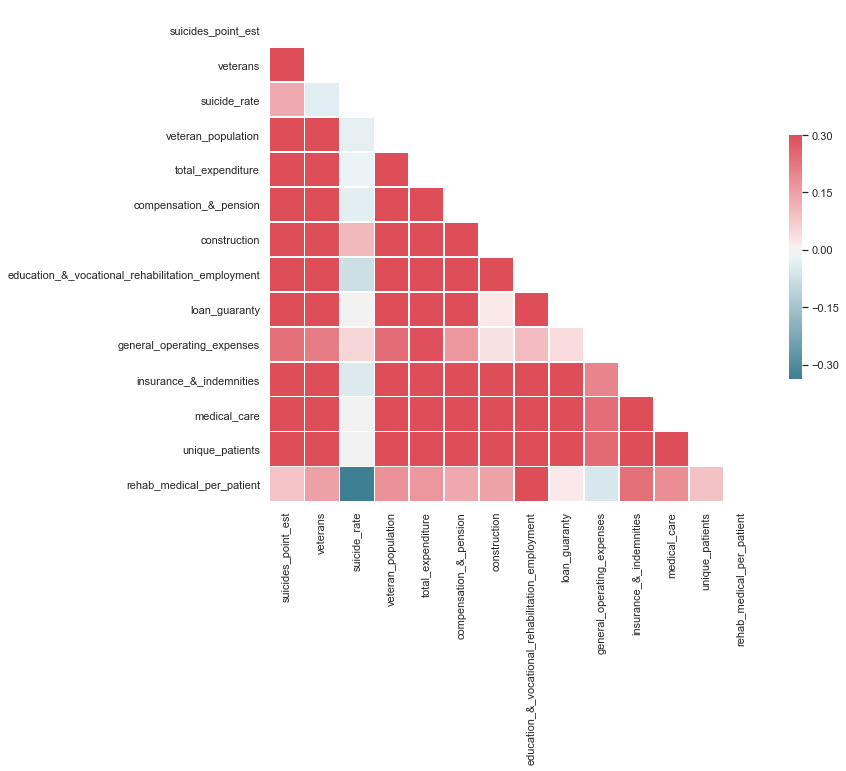

In [34]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = state_data_wide.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

AttributeError: module 'seaborn' has no attribute 'plt'

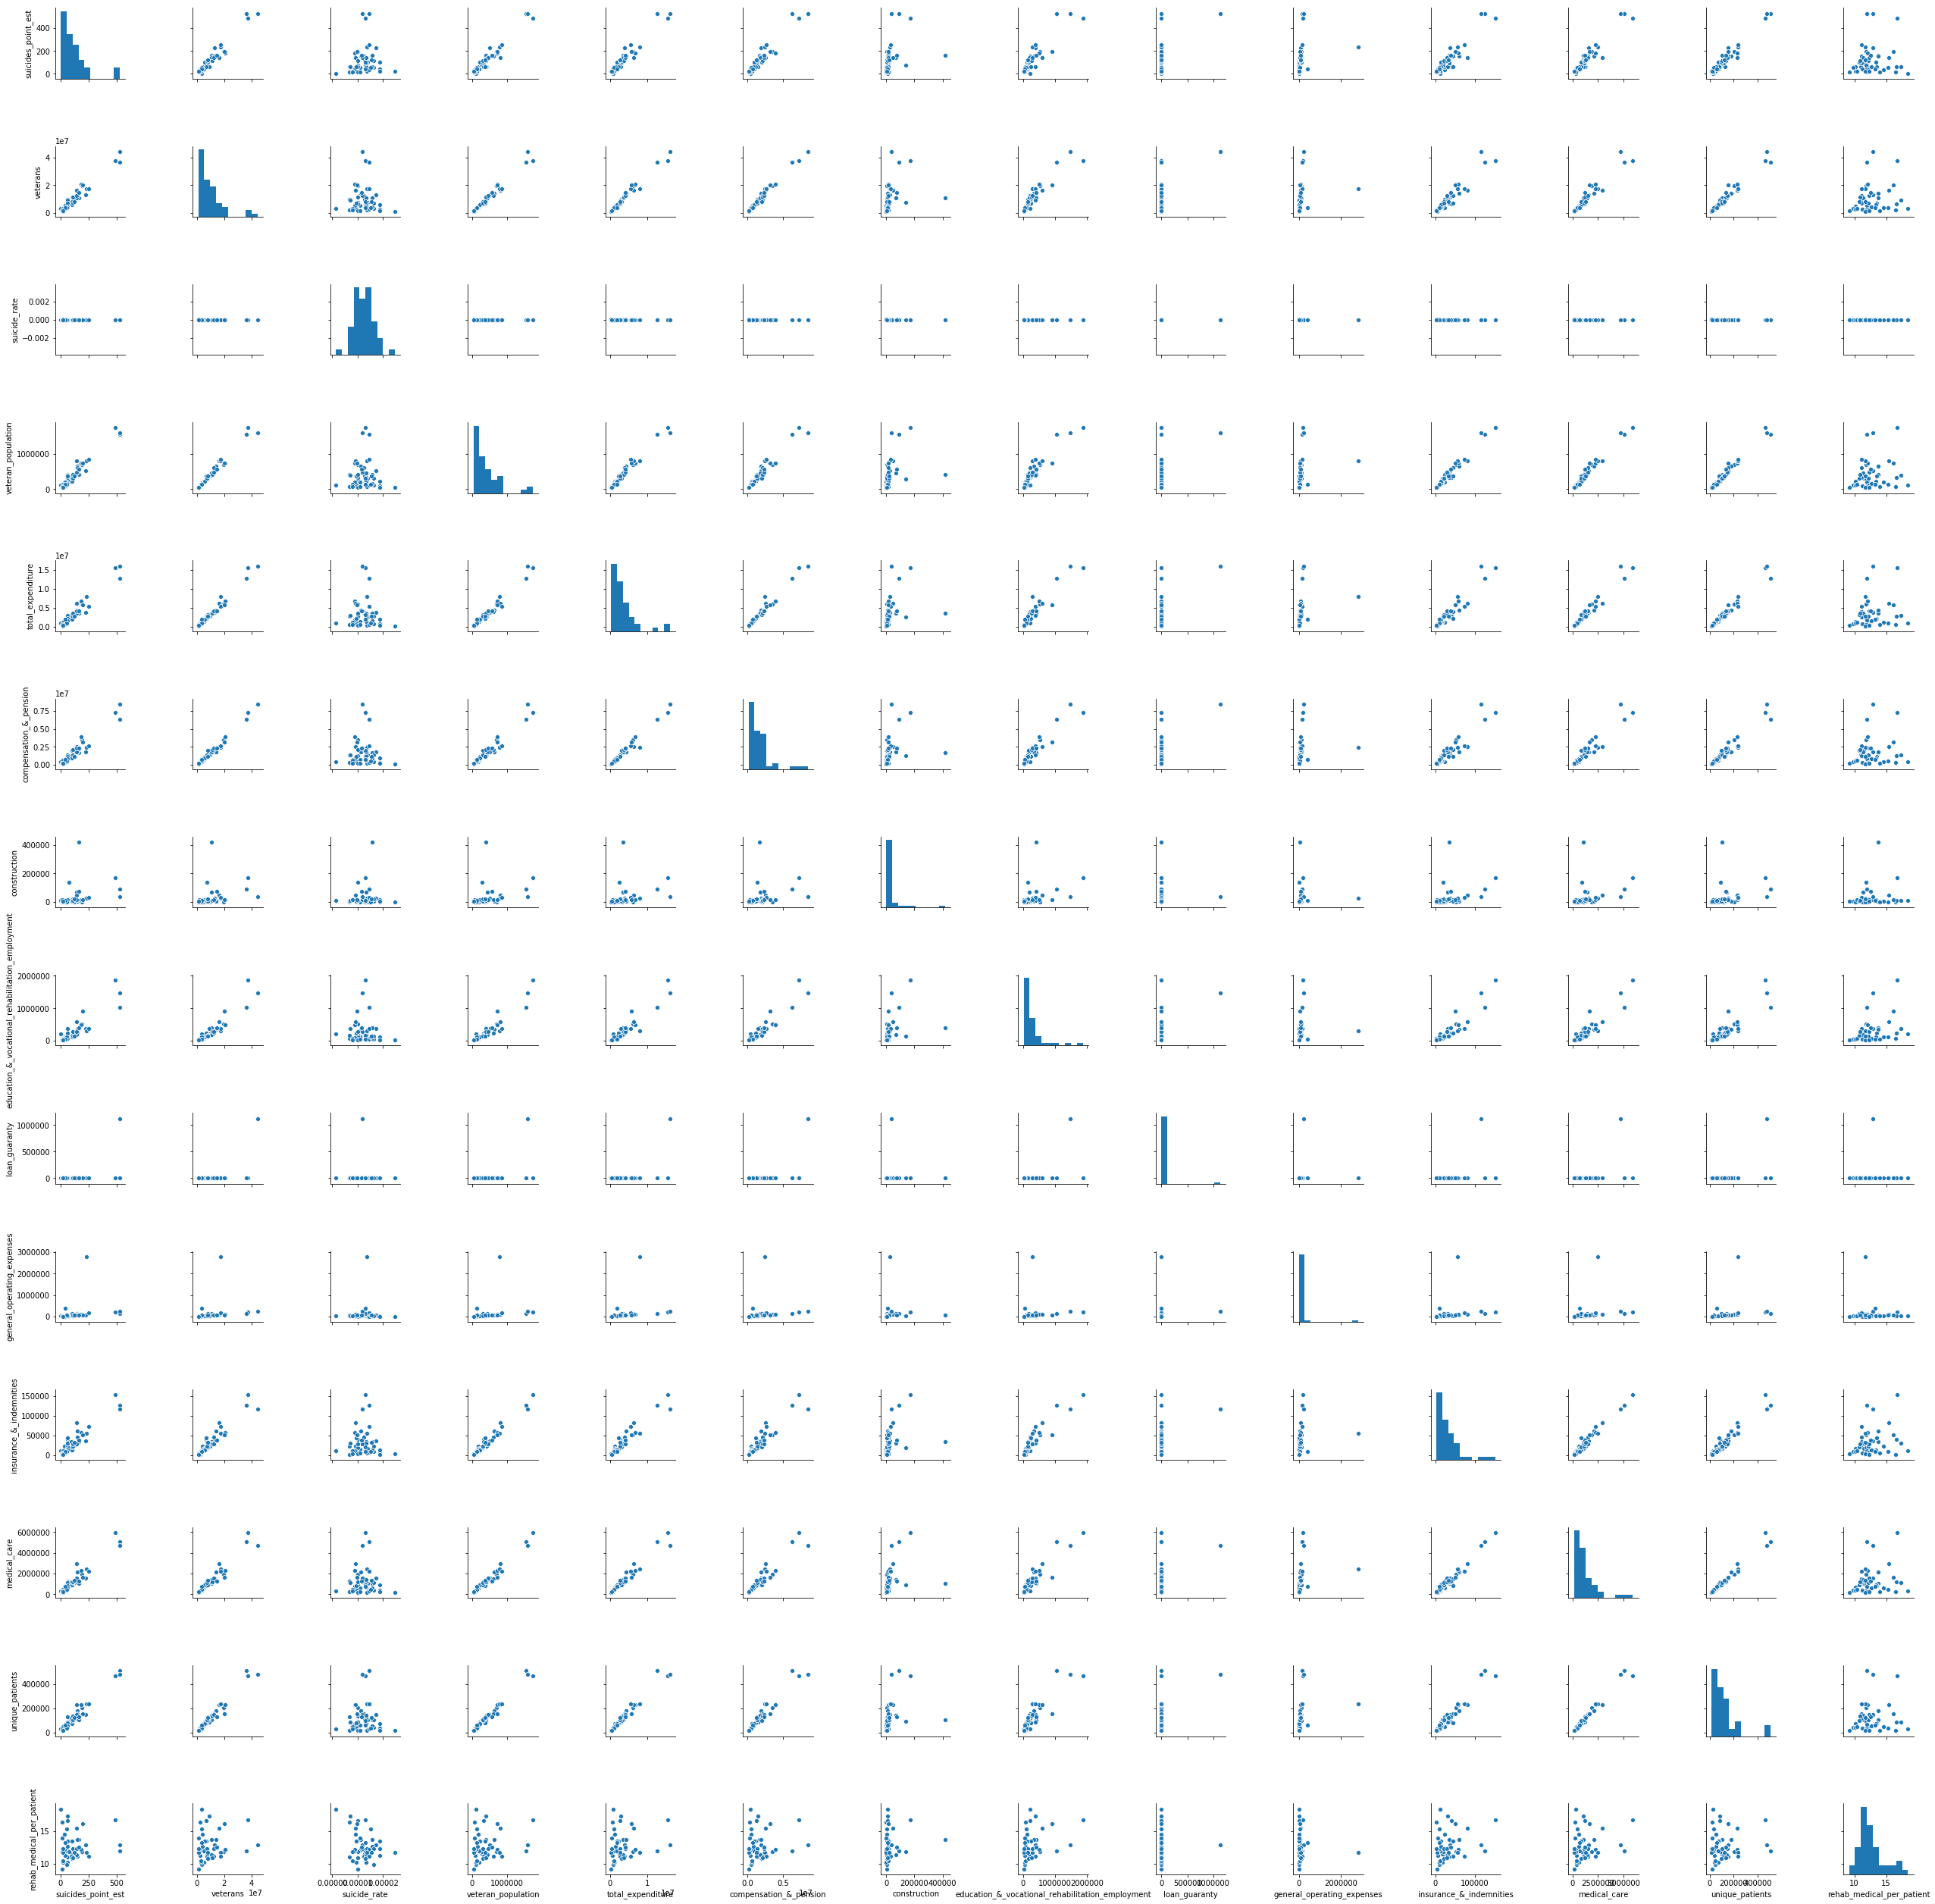

In [32]:
sns.pairplot(state_data_wide.drop(columns='state', axis=1)); sns.plt.show()

The heatmap indicates that no two of the features have a absolute correlation more than 0.3. However, consider the pairwise correlation plots above: going across the rows, we can see that features like veteran_population, educational & vocational rehabilitation employment, and medical care appear to have relatively linear relationships with many of the other features. Let's redraw these pairwise scatterplots with fewer features:

Plot heat map of correlations

Regression model 

# Suicides by Age

TO DO:
* Remove '<' and '-' (ranges) from veteran_suicides and general_population_suicides 
* Remove '--', '*' from rate columns 

# Suicides by Method

TO DO:
* Remove ',', '<', from suicides
* Replace '--' from group_percentage 